# Evaluation of metadata predictions

#### Load necessary packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import Levenshtein

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


#### Load embedding model

In [2]:
nlp = spacy.load('../models/embeddings/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


#### Load predictions and actual metadata for a given class

In [44]:
predicted_class = 'Age'
model_iter = 'model_v1'

In [45]:
predicted_df = pd.read_pickle(
    '../results/{mymodel}/predictions/{myclass}_prediction.pickle'.format(mymodel = model_iter, myclass = predicted_class))
class_validation = pd.read_pickle(
    '../results/{mymodel}/validation/{myclass}_validation_values.pickle'.format(mymodel = model_iter, myclass = predicted_class))
validation_data = pd.read_pickle(
    '../results/{mymodel}/validation/{myclass}_validation_set.pickle'.format(mymodel = model_iter, myclass = predicted_class))

#### Create dataframe

In [46]:
class_df = predicted_df[predicted_df['predicted'] == predicted_class]

In [47]:
tmp_df = class_validation.loc[class_df['srs'].values]
tmp_df = tmp_df.loc[~tmp_df.index.duplicated(keep = 'first')]

In [48]:
class_df['actual'] = tmp_df.loc[class_df['srs'].values]['value'].values

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Overall prediction stats

In [49]:
predicted_count = class_df.shape[0]
print(('%d/%d (%.2f%%) predicted as %s\n' % 
       (predicted_count, len(validation_data), predicted_count/len(validation_data)*100, predicted_class)))

98/913 (10.73%) predicted as Age



In [50]:
missing_df = class_validation[~class_validation.index.isin(class_df['srs'].values)]
missing = validation_data[~validation_data.index.get_level_values(0).isin(class_df['srs'].values)]
if missing_df.shape[0] == len(missing):  # if there are not duplicate srs predictions
    missing_df['TITLE'] = missing.values

In [51]:
missing_df.to_csv(
    '../results/{model}/predictions/{myclass}_missing.csv'.format(model = model_iter, myclass = predicted_class))

#### Exact matches

In [52]:
num_correct = class_df[class_df['token'] == class_df['actual']].shape[0]
print(('%d/%d (%.2f%%) exact matches predicted as %s\n' % 
       (num_correct, predicted_count, num_correct/predicted_count*100, predicted_class)))

20/98 (20.41%) exact matches predicted as Age



Correctly predicted had mean score of 0.71



10 month     4
6 months     4
6 month      3
10 months    3
2 month      3
Name: actual, dtype: int64

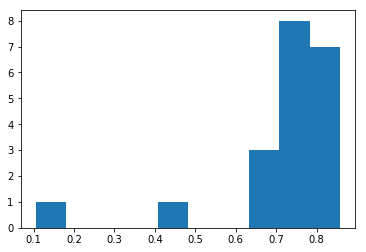

In [53]:
exact_correct_df = class_df[(class_df['token'] == class_df['actual'])]
plt.hist(exact_correct_df['score'])
print('Correctly predicted had mean score of %.2f\n' % exact_correct_df['score'].mean())
exact_correct_df['actual'].value_counts().head()

exact_incorrectly predicted had mean score of 0.64



E18           4
P2            3
38            3
28            3
3 year old    2
Name: actual, dtype: int64

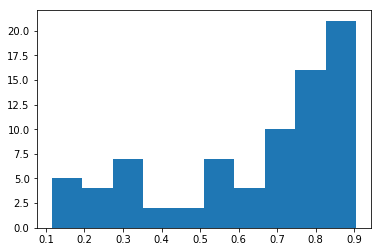

In [57]:
exact_incorrect_df = class_df[(class_df['token'] != class_df['actual'])]
plt.hist(exact_incorrect_df['score'])
print(('exact_incorrectly predicted had mean score of %.2f\n' % exact_incorrect_df['score'].mean()))
exact_incorrect_df['actual'].value_counts().head()

In [59]:
exact_correct_df.to_csv(
    '../results/{model}/predictions/{myclass}_correct.csv'.format(model = model_iter, myclass = predicted_class))
exact_incorrect_df.to_csv(
    '../results/{model}/predictions/{myclass}_incorrect.csv'.format(model = model_iter, myclass = predicted_class))

#### Contained within

In [60]:
actual = class_df['actual'].values
predic = class_df['token'].values
count = 0
index = []
for i in range(len(actual)):
    if (predic[i] in actual[i]) or (actual[i] in predic[i]):
        count = count + 1
        index.append(class_df.iloc[i].srs)
print(('%d/%d (%.2f%%) of predicted contained in actual for %s\n' % 
       (count, predicted_count, count/predicted_count*100, predicted_class)))

42/98 (42.86%) of predicted contained in actual for Age



#### Cosine similarity

In [61]:
predicted_docs = nlp.pipe(class_df['token'].tolist())
predicted_vectors = np.array([doc.vector for doc in predicted_docs])

actual_docs = nlp.pipe(class_df['actual'].tolist())
actual_vectors = np.array([doc.vector for doc in actual_docs])

In [62]:
similarities = []
for i in range(len(predicted_vectors)):
    cosine_sim = cosine_similarity(predicted_vectors[i].reshape(1,200), actual_vectors[i].reshape(1,200))
    similarities.append(float(cosine_sim))

In [63]:
similar_df = pd.DataFrame({'predicted': class_df['token'].tolist(), 
                  'actual': class_df['actual'].tolist(), 
                  'cosine similarity': similarities})

(array([ 5., 13.,  0.,  2.,  4.,  5.,  7., 27., 11., 24.]),
 array([-0.01324915,  0.08807577,  0.18940068,  0.2907256 ,  0.39205051,
         0.49337543,  0.59470034,  0.69602526,  0.79735017,  0.89867509,
         1.        ]),
 <a list of 10 Patch objects>)

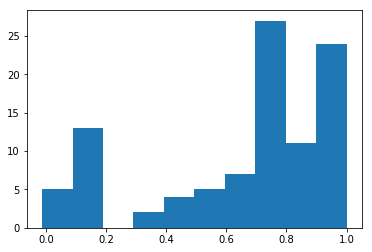

In [64]:
plt.hist(similar_df['cosine similarity'])

In [65]:
sim_threshold = 0.8
num_sim = similar_df[similar_df['cosine similarity'].values > sim_threshold].shape[0]
print(('%d/%d (%.2f%%) Predicted with cosine similarity greater than %.1f\n' 
                     % (num_sim, predicted_count, num_sim/predicted_count*100, sim_threshold)))

31/98 (31.63%) Predicted with cosine similarity greater than 0.8



#### BLEU scoring

In [66]:
def bleu1(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(1, 0, 0, 0), smoothing_function=smoother.method1)

def bleu4(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

In [67]:
smoother = SmoothingFunction()
similar_df["BLUE1"] = similar_df.apply(bleu1, axis=1)
similar_df["BLUE4"] = similar_df.apply(bleu4, axis=1)

#### Levenshtein distance

In [68]:
def levenshtein(x):
    return Levenshtein.distance(x["predicted"], x["actual"])

In [69]:
similar_df["levenshtein"] = similar_df.apply(levenshtein, axis=1)

In [70]:
similar_df

,predicted,actual,cosine similarity,BLUE1,BLUE4,levenshtein
0,15 DPA,15 DPA,1.000000,1.000000,0.033333,0
1,hours post,7 days old,0.572107,0.300000,0.014286,8
2,afternoon day,60,0.137448,0.000000,0.000000,13
3,post exposure,juvenile,0.074568,0.250000,0.020000,11
4,2 week,6 weeks,0.807179,0.571429,0.025000,2
5,2 week,7 days old,0.699664,0.100000,0.014286,9
6,2014 Sum,3,-0.013249,0.000000,0.000000,8
7,day old,3 days after eclosion,0.674051,0.285714,0.005556,16
8,5 Ngn3^GFP/+,embryonic day 15.5,0.320646,0.166667,0.006667,17
9,5 day,14.5 day,0.766225,0.625000,0.020000,3
